In [559]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import fairlearn
from fairlearn.metrics import MetricFrame
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [560]:
import warnings
warnings.filterwarnings("ignore")

In [561]:
def group_pivot(labelgroup, yvalue, dataset, SZOnly = False):
    if SZOnly:
        dataset = dataset.loc[dataset.Diagnosis == 0]
    
    grouped = (dataset.groupby([labelgroup])[yvalue].value_counts(normalize = True).rename('percentage').reset_index())
    pivot = pd.pivot_table(grouped, index = labelgroup, columns = yvalue, values = 'percentage', aggfun = 'sum')
    return pivot

Import data

In [562]:
data = pd.read_csv('/Users/dahaixing/Documents/Coursework/DeepLearning/MLCW/MachineLearningCW/MS4S16_Dataset.csv')

1. Data preprocessing and EDA 

1.1 Summary of statistics 

In [563]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Diagnosis           5000 non-null   int64  
 1   Anhedonia           5000 non-null   float64
 2   Apathy              5000 non-null   float64
 3   Appetite            5000 non-null   float64
 4   Concentration       5000 non-null   float64
 5   Content             5000 non-null   float64
 6   Delay               5000 non-null   object 
 7   Delusion            5000 non-null   float64
 8   Dep_Mood            5000 non-null   float64
 9   Focus               5000 non-null   float64
 10  Hallucination       5000 non-null   float64
 11  Housing             5000 non-null   object 
 12  Intrusive_Thoughts  4170 non-null   float64
 13  Participant         5000 non-null   int64  
 14  Passive             5000 non-null   float64
 15  Pregnant            2762 non-null   float64
 16  Psycho

There are 26 predictor variables and 1 target variable. Among predictor variables, 4 are categorical variables. 

In [564]:
num_var = [
 'Anhedonia',
 'Apathy',
 'Appetite',
 'Concentration',
 'Content',
 'Delusion',
 'Dep_Mood',
 'Focus',
 'Hallucination',
 'Intrusive_Thoughts',
 'Passive',
 'Pregnant',
 'Psychomotor',
 'Rumination',
 'Sleep',
 'Stress',
 'Suspicious',
 'Tension',
 'Tired',
 'Unusual_Thought',
 'Withdrawal']

categories = ['Sex','Race','Housing','Delay'] 

In [565]:
data.describe()

,Diagnosis,Anhedonia,Apathy,Appetite,Concentration,Content,Delusion,Dep_Mood,Focus,Hallucination,...,Pregnant,Psychomotor,Rumination,Sleep,Stress,Suspicious,Tension,Tired,Unusual_Thought,Withdrawal
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,2762.000000,5000.000000,5000.000000,5000.000000,5000.000000,2127.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.505800,6.502860,2.478849,27.070029,6.519924,0.279407,2.637389,5.727062,6.519924,65.073832,...,0.101376,4.680583,5.685816,7.011266,4.916418,2.754909,4.920667,inf,2.480266,3.958121
std,0.500016,1.488151,1.730810,14.202618,1.474846,0.834494,1.440347,3.284501,1.474846,223.943469,...,0.301880,1.482692,2.161891,1.410841,2.220262,1.496126,1.962342,NaN,1.410475,1.469444
min,0.000000,1.098854,-3.211011,0.141074,1.299964,0.000187,-2.127037,0.000000,1.299964,0.027350,...,0.000000,-0.024974,-0.409032,2.144726,-3.257788,-2.346238,-2.183456,0.366650,-1.981307,-0.825919
25%,0.000000,5.495361,1.265128,16.724108,5.528181,0.018655,1.629919,4.678095,5.528181,4.113962,...,0.000000,3.697870,4.042552,6.058402,3.443683,1.703462,3.565482,4.491580,1.486439,2.969534
50%,1.000000,6.485527,2.427409,25.165292,6.498042,0.064259,2.558146,6.752196,6.498042,12.764604,...,0.000000,4.720156,5.521805,6.980519,5.096416,2.735108,5.247353,5.513508,2.388994,3.962131
75%,1.000000,7.489218,3.642059,35.447666,7.519759,0.215773,3.588012,8.045706,7.519759,41.814204,...,0.000000,5.682627,7.276673,7.977138,6.531673,3.725759,6.385145,6.569176,3.426667,4.972302
max,1.000000,11.603140,8.803433,113.438734,11.649649,21.001327,8.978785,12.003550,11.649649,6287.163151,...,1.000000,10.171540,12.009666,11.920312,11.970952,8.212275,9.622076,inf,8.066822,9.022207


In [566]:
# check for class imbalance
# Check the count of each class
class_counts = data['Diagnosis'].value_counts()

# Print the class counts
print(class_counts)

# Check the class balance
class_balance = class_counts/class_counts.sum()

# Print the class balance
print(class_balance)

1    2529
0    2471
Name: Diagnosis, dtype: int64
1    0.5058
0    0.4942
Name: Diagnosis, dtype: float64


- Variables 'Intrusive_Thoughts' and 'Pregnant' have significant number of null values, we impute 'Intrusive_Thoughts' with mean values. For 'Pregnant', the missing value asscoaited with males, thus we impute it with 0. 
- Variable 'Tired' has 'NaN' and 'inf' values, we impute the NaN with mean values, and replace inf with max values of the column. 
- variale 'Hallucination' has value range (0, 6287), significantly bigger than other variables, thus we need to standardize them. 
- 'Participant' is constant at 1. so remove this variable. 
- no class imbalance in the data

Below we create a data processing function to tackle the issues above. 

In [567]:
def data_remove(data):
    data['Pregnant'].fillna(0, inplace=True)
    data.fillna(data.mean(), inplace=True)
    data = data.replace([np.inf, -np.inf], np.nan)
    data['Tired'] = data['Tired'].replace(np.nan, data['Tired'].max())
    # Create a copy of the dataframe
    data_standardized = data.copy()
    # Initialize the StandardScaler
    scaler = StandardScaler()
    # Fit and transform the selected columns
    data_standardized[num_var] = scaler.fit_transform(data[num_var])
    return data_standardized
    

In [568]:
features = [
 'Anhedonia',
 'Apathy',
 'Appetite',
 'Concentration',
 'Content',
 'Delay',
 'Delusion',
 'Dep_Mood',
 'Focus',
 'Hallucination',
 'Housing',
 'Intrusive_Thoughts',
 'Passive',
 'Pregnant',
 'Psychomotor',
 'Race',
 'Rumination',
 'Sex',
 'Sleep',
 'Stress',
 'Suspicious',
 'Tension',
 'Tired',
 'Unusual_Thought',
 'Withdrawal']

In [569]:
# drop duplicate rows if it occurs, keeping the first occurrence
data = data.drop_duplicates(ignore_index=True)

In [570]:
#data preprocessing 
#split the training and testing datasets
data = data.drop(['Participant'], axis=1)
y = data['Diagnosis']
X = data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

train = pd.concat([X_train,y_train], axis= 1)
test = pd.concat([X_test,y_test], axis= 1)
train = data_remove(train)
test = data_remove(test)


In [571]:
X_train = pd.get_dummies(train[features], columns = categories)
X_test = pd.get_dummies(test[features], columns = categories)
y_train = train[['Diagnosis']]
y_test = test[['Diagnosis']]


In [572]:
test.describe()

,Anhedonia,Apathy,Appetite,Concentration,Content,Delusion,Dep_Mood,Focus,Hallucination,Intrusive_Thoughts,...,Psychomotor,Rumination,Sleep,Stress,Suspicious,Tension,Tired,Unusual_Thought,Withdrawal,Diagnosis
count,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,...,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03,1500.000000
mean,3.348433e-16,-2.133849e-16,2.253013e-16,-4.144092e-16,-3.467597e-17,-9.666342e-17,1.052862e-16,-4.144092e-16,3.175238e-17,-4.292862e-17,...,1.327827e-16,-2.086479e-16,-1.280457e-17,1.371866e-16,-2.494721e-16,2.612725e-17,-7.616130e-17,-9.336976e-17,4.199604e-16,0.503333
std,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,...,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,0.500156
min,-3.105044e+00,-3.247045e+00,-1.868133e+00,-3.607416e+00,-3.678987e-01,-3.344433e+00,-1.752992e+00,-3.607416e+00,-3.261208e-01,-3.194941e+00,...,-3.123772e+00,-2.440347e+00,-3.080853e+00,-3.751789e+00,-4.259714e+00,-3.621009e+00,-3.357697e+00,-2.712565e+00,-2.912690e+00,0.000000
25%,-6.783304e-01,-7.015765e-01,-7.345600e-01,-6.708763e-01,-3.440007e-01,-6.916365e-01,-2.998024e-01,-6.708763e-01,-3.036039e-01,-6.683758e-01,...,-6.522903e-01,-7.611916e-01,-6.770406e-01,-6.681330e-01,-4.650882e-16,-6.918020e-01,-6.855613e-01,-7.149721e-01,-7.023627e-01,0.000000
50%,5.610957e-04,-2.976391e-02,-1.443831e-01,7.183055e-03,-2.870020e-01,-4.630373e-02,3.156091e-01,7.183055e-03,-2.553230e-01,-4.026965e-16,...,3.621066e-02,-9.401138e-02,-3.293031e-02,9.158254e-02,-4.650882e-16,1.855414e-01,-5.730076e-03,-6.649500e-02,8.174238e-03,1.000000
75%,6.489530e-01,6.886129e-01,5.781262e-01,6.721870e-01,-8.592905e-02,6.600481e-01,7.010470e-01,6.721870e-01,-1.026041e-01,5.622440e-01,...,6.752437e-01,7.262527e-01,6.849644e-01,7.190179e-01,-4.650882e-16,7.446024e-01,6.351650e-01,6.786998e-01,6.946479e-01,1.000000
max,3.317347e+00,3.235758e+00,4.995086e+00,2.840242e+00,1.384740e+01,4.451962e+00,1.699726e+00,2.840242e+00,1.516471e+01,3.084644e+00,...,3.335335e+00,2.900773e+00,2.840058e+00,3.170560e+00,4.583319e+00,2.361730e+00,2.827121e+00,3.228128e+00,3.046408e+00,1.000000


In [573]:
#corr analysis
X_train.corr().style.background_gradient()

,Anhedonia,Apathy,Appetite,Concentration,Content,Delusion,Dep_Mood,Focus,Hallucination,Intrusive_Thoughts,Passive,Pregnant,Psychomotor,Rumination,Sleep,Stress,Suspicious,Tension,Tired,Unusual_Thought,Withdrawal,Sex_Female,Sex_Male,Race_Asian,Race_Black,Race_Hispanic,Race_White,Housing_Stable,Housing_Unstable,Delay_No,Delay_Yes
Anhedonia,1.000000,-0.086490,0.026919,-0.103070,0.030301,-0.137265,0.004196,-0.103070,-0.052168,0.171602,0.018361,0.008453,0.080226,0.195762,-0.010335,-0.136612,-0.055253,-0.162032,0.103181,-0.112546,-0.088242,0.086138,-0.086138,0.014009,-0.054737,0.028352,0.023548,0.055686,-0.055686,0.058293,-0.058293
Apathy,-0.086490,1.000000,0.009727,0.102104,-0.054583,0.146089,-0.029489,0.102104,0.023066,-0.165879,-0.016051,-0.015820,-0.075215,-0.194106,0.018632,0.149735,0.070052,0.171474,-0.078161,0.817854,0.090079,-0.092098,0.092098,-0.026206,0.074327,-0.042147,-0.024226,-0.057835,0.057835,-0.068295,0.068295
Appetite,0.026919,0.009727,1.000000,-0.016695,-0.040938,-0.013685,-0.021779,-0.016695,-0.014635,0.018122,0.008302,-0.006226,-0.028100,0.025361,-0.003034,0.019436,0.013499,0.023193,0.002114,0.012641,0.003749,0.018953,-0.018953,0.030664,0.009504,-0.023133,-0.014725,-0.009704,0.009704,-0.014291,0.014291
Concentration,-0.103070,0.102104,-0.016695,1.000000,-0.030534,0.107162,-0.045327,1.000000,0.030818,-0.158584,-0.018210,0.001781,-0.080512,-0.197706,-0.034890,0.181539,0.051911,0.178540,-0.104567,0.123096,0.067334,-0.086999,0.086999,-0.038266,0.084588,-0.036957,-0.029412,-0.055391,0.055391,-0.056350,0.056350
Content,0.030301,-0.054583,-0.040938,-0.030534,1.000000,-0.064830,0.044515,-0.030534,-0.031492,0.050450,-0.013894,0.046322,0.018463,0.065709,-0.022983,-0.051129,-0.296669,-0.064600,0.055467,-0.060447,-0.048412,0.051825,-0.051825,0.031713,-0.066937,0.028718,0.022628,0.017373,-0.017373,0.013121,-0.013121
Delusion,-0.137265,0.146089,-0.013685,0.107162,-0.064830,1.000000,-0.042319,0.107162,0.439229,-0.212307,-0.014022,-0.026670,-0.101987,-0.254437,0.021206,0.186675,0.104502,0.216320,-0.110721,0.171372,0.100686,-0.141339,0.141339,-0.043124,0.068528,-0.059502,0.006006,-0.043339,0.043339,-0.076698,0.076698
Dep_Mood,0.004196,-0.029489,-0.021779,-0.045327,0.044515,-0.042319,1.000000,-0.045327,-0.008122,0.020984,-0.407480,-0.005597,0.028072,0.009514,0.009074,-0.054652,-0.033844,-0.061168,0.082368,-0.038637,-0.043367,-0.010126,0.010126,0.022333,-0.043013,0.039952,-0.002248,-0.001900,0.001900,0.023380,-0.023380
Focus,-0.103070,0.102104,-0.016695,1.000000,-0.030534,0.107162,-0.045327,1.000000,0.030818,-0.158584,-0.018210,0.001781,-0.080512,-0.197706,-0.034890,0.181539,0.051911,0.178540,-0.104567,0.123096,0.067334,-0.086999,0.086999,-0.038266,0.084588,-0.036957,-0.029412,-0.055391,0.055391,-0.056350,0.056350
Hallucination,-0.052168,0.023066,-0.014635,0.030818,-0.031492,0.439229,-0.008122,0.030818,1.000000,-0.096470,0.013198,-0.029517,-0.075931,-0.110623,0.015881,0.099708,0.049182,0.112919,-0.031605,0.050860,0.025933,-0.075549,0.075549,-0.036271,0.024918,-0.044514,0.033290,-0.008670,0.008670,-0.038820,0.038820
Intrusive_Thoughts,0.171602,-0.165879,0.018122,-0.158584,0.050450,-0.212307,0.020984,-0.158584,-0.096470,1.000000,0.033844,0.077330,0.148775,0.823221,-0.001634,-0.097753,-0.116068,-0.117418,0.158583,-0.196690,-0.073516,0.447787,-0.447787,0.010341,-0.084087,0.021115,0.060234,0.069115,-0.069115,0.068711,-0.068711


In [574]:
from scipy import stats
# Create histograms for each column

# Perform normality test for each column
for col in X_train.columns:
    print(f"Column {col} normality test:")
    print(stats.normaltest(X_train[col]))

Column Anhedonia normality test:
NormaltestResult(statistic=2.8301802075461713, pvalue=0.24290372592048082)
Column Apathy normality test:
NormaltestResult(statistic=11.85520897368157, pvalue=0.0026648580512857616)
Column Appetite normality test:
NormaltestResult(statistic=433.65340389270665, pvalue=6.813336136432135e-95)
Column Concentration normality test:
NormaltestResult(statistic=1.5775988596932233, pvalue=0.45438999500761534)
Column Content normality test:
NormaltestResult(statistic=6069.247135307169, pvalue=0.0)
Column Delusion normality test:
NormaltestResult(statistic=46.67087783721611, pvalue=7.33749206943054e-11)
Column Dep_Mood normality test:
NormaltestResult(statistic=453.15690290752224, pvalue=3.96486875100807e-99)
Column Focus normality test:
NormaltestResult(statistic=1.5775988596932233, pvalue=0.45438999500761534)
Column Hallucination normality test:
NormaltestResult(statistic=6063.444250566946, pvalue=0.0)
Column Intrusive_Thoughts normality test:
NormaltestResult(sta

In [575]:
#Logistc regression training 

LGmodel = LogisticRegression(penalty='elasticnet', max_iter= 1000, solver= 'saga', l1_ratio=1)
LGmodel.fit(X_train, y_train)
LG_test_predict = LGmodel.predict(X_test)

In [576]:
print('LG test accuracy:', skm.accuracy_score(y_test, LG_test_predict))

LG test accuracy: 0.9246666666666666


In [577]:
print(classification_report(y_test, LG_test_predict, labels=[1, 0]))

              precision    recall  f1-score   support

           1       0.93      0.92      0.93       755
           0       0.92      0.92      0.92       745

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500



In [578]:
confusion_matrix = confusion_matrix(y_test, LG_test_predict, labels=[1, 0])
print(confusion_matrix)

[[698  57]
 [ 56 689]]


In [579]:
def race_fp(truelabels, predictions):
  sesitive = test.Race
  fmetrics = MetricFrame(metrics= fairlearn.metrics.false_positive_rate, 
                         y_true=truelabels, 
                         y_pred=predictions,
                         sensitive_features=sesitive)
  results = pd.DataFrame([fmetrics.by_group, fmetrics.by_group/fmetrics.by_group.White], 
                         index= ['FPR', 'FPR Parity'])
  return results

In [580]:
race_fp(y_test, LG_test_predict)

Race,Asian,Black,Hispanic,White
FPR,0.028986,0.135678,0.090909,0.047101
FPR Parity,0.615385,2.880557,1.930070,1.000000


In [581]:
def raceNsex_fp(truelabels, predictions):
  sesitive = pd.DataFrame(np.stack([test.Race, test.Sex], axis = 1),
                          columns = ['Race','Sex']) 
  fmetrics = MetricFrame(metrics= fairlearn.metrics.false_positive_rate, 
                         y_true=truelabels, 
                         y_pred=predictions,
                         sensitive_features=sesitive)
  results = pd.DataFrame([fmetrics.by_group, fmetrics.by_group/fmetrics.by_group.White.Male], 
                         index= ['FPR', 'FPR Parity'])
  return results

In [582]:
raceNsex_fp(y_test, LG_test_predict)

Race           Asian               Black            Hispanic            White  \
Sex           Female      Male    Female      Male    Female      Male Female   
FPR         0.025316  0.033898  0.137500  0.128205  0.089744  0.092593    0.0   
FPR Parity  0.210321  0.281617  1.142308  1.065089  0.745562  0.769231    0.0   

Race                 
Sex            Male  
FPR         0.12037  
FPR Parity  1.00000

In [583]:
def race_fn(truelabels, predictions):
  sesitive = test.Race
  fmetrics = MetricFrame(metrics= fairlearn.metrics.false_negative_rate, 
                         y_true=truelabels, 
                         y_pred=predictions,
                         sensitive_features=sesitive)
  results = pd.DataFrame([fmetrics.by_group, fmetrics.by_group/fmetrics.by_group.White], 
                         index= ['FNR', 'FNR Parity'])
  return results

In [584]:
race_fn(y_test, LG_test_predict)

Race,Asian,Black,Hispanic,White
FNR,0.061728,0.067485,0.073684,0.090909
FNR Parity,0.679012,0.742331,0.810526,1.000000


In [585]:
def raceNsex_fn(truelabels, predictions):
  sesitive = pd.DataFrame(np.stack([test.Race, test.Sex], axis = 1),
                          columns = ['Race','Sex']) 
  fmetrics = MetricFrame(metrics= fairlearn.metrics.false_negative_rate, 
                         y_true=truelabels, 
                         y_pred=predictions,
                         sensitive_features=sesitive)
  results = pd.DataFrame([fmetrics.by_group, fmetrics.by_group/fmetrics.by_group.White.Male], 
                         index= ['FNR', 'FNR Parity'])
  return results

In [586]:
raceNsex_fn(y_test, LG_test_predict)

Race           Asian               Black            Hispanic            \
Sex           Female      Male    Female      Male    Female      Male   
FNR         0.045455  0.081081  0.109091  0.046296  0.122449  0.021739   
FNR Parity  1.009091  1.800000  2.421818  1.027778  2.718367  0.482609   

Race           White            
Sex           Female      Male  
FNR         0.126761  0.045045  
FNR Parity  2.814085  1.000000

Model 2: Decision trees

In [587]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [588]:
DT_model = DecisionTreeClassifier()
DT_model = DT_model.fit(X_train, y_train)

In [589]:
DT_test_predictions = DT_model.predict(X_test)

In [590]:
print('DT test accuracy:', skm.accuracy_score(y_test, DT_test_predictions))

DT test accuracy: 0.864


Model SVM

In [591]:
from sklearn import svm
svm_model = svm.SVC(kernel='linear')
svm_model = svm_model.fit(X_train, y_train)
svm_test_predictions = svm_model.predict(X_test)

In [592]:
print('SVM test accuracy:', skm.accuracy_score(y_test, svm_test_predictions))

SVM test accuracy: 0.9253333333333333


Light GBM model

In [593]:
# Define the LightGBM model
model = lgb.LGBMClassifier()

# Train the model
model.fit(X_train, y_train)

# Get the predicted probabilities for the test set
y_probs = model.predict_proba(X_test)[:, 1]

# Create an array of threshold values
thresholds = np.arange(0, 1.01, 0.01)

# Initialize an empty list to store the AUC scores
scores = []

# Iterate over the threshold values
for t in thresholds:
    # Convert the predicted probabilities to class labels using the current threshold
    y_pred = (y_probs > t).astype(int)
    # Calculate the AUC score for the current threshold
    score = roc_auc_score(y_test, y_pred)
    # Append the score to the list
    scores.append(score)

# Find the threshold that corresponds to the highest AUC score
best_threshold = thresholds[np.argmax(scores)]

print(f'The optimal threshold is {best_threshold:.2f}')

The optimal threshold is 0.58


In [594]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
params = {'objective': 'binary', 'metric': 'binary_logloss'}
LGB_model = lgb.train(params, train_data)
# Predict on the test data
LGB_test_predictions = LGB_model.predict(X_test)

# Convert the predicted probabilities to binary labels
LGB_test_predictions = (LGB_test_predictions > 0.58).astype(int)

[LightGBM] [Info] Number of positive: 1774, number of negative: 1726
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5123
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506857 -> initscore=0.027430
[LightGBM] [Info] Start training from score 0.027430


In [595]:
print('LGB test accuracy:', skm.accuracy_score(y_test, LGB_test_predictions))

LGB test accuracy: 0.9433333333333334


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

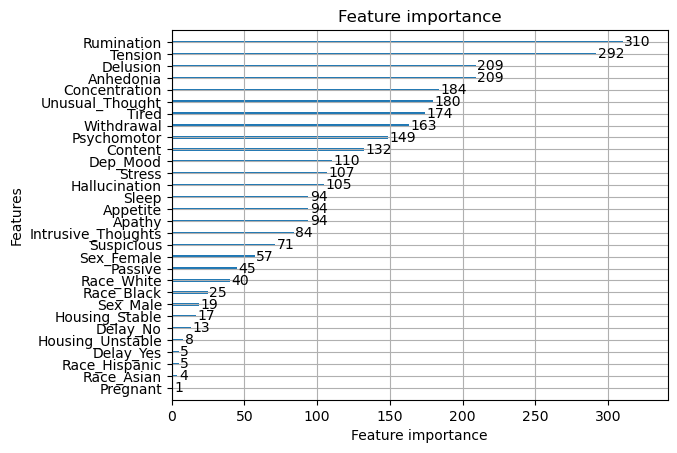

In [596]:
lgb.plot_importance(LGB_model)

In [597]:
raceNsex_fp(y_test, LGB_test_predictions)

Race           Asian             Black            Hispanic            \
Sex           Female      Male  Female      Male    Female      Male   
FPR         0.012658  0.033898  0.0875  0.102564  0.051282  0.055556   
FPR Parity  0.151899  0.406780  1.0500  1.230769  0.615385  0.666667   

Race           White            
Sex           Female      Male  
FPR         0.017857  0.083333  
FPR Parity  0.214286  1.000000

In [598]:
race_fp(y_test, LGB_test_predictions)

Race,Asian,Black,Hispanic,White
FPR,0.021739,0.090452,0.053030,0.043478
FPR Parity,0.500000,2.080402,1.219697,1.000000


In [599]:
print(classification_report(y_test, LGB_test_predictions, labels=[1, 0]))

              precision    recall  f1-score   support

           1       0.95      0.94      0.94       755
           0       0.94      0.95      0.94       745

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.94      0.94      0.94      1500



We choose Light GBM as classification model, next we do cross-validation

In [600]:
cv_data = data
cv_data = data_remove(cv_data)




In [601]:
y = cv_data[['Diagnosis']]

In [602]:

X = pd.get_dummies(cv_data[features], columns = categories)
X.describe()

,Anhedonia,Apathy,Appetite,Concentration,Content,Delusion,Dep_Mood,Focus,Hallucination,Intrusive_Thoughts,...,Sex_Female,Sex_Male,Race_Asian,Race_Black,Race_Hispanic,Race_White,Housing_Stable,Housing_Unstable,Delay_No,Delay_Yes
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.783462e-16,8.345408e-17,3.161027e-16,-1.657986e-16,3.488876e-17,-7.234213e-17,1.341330e-16,-1.657986e-16,2.612355e-17,2.201350e-16,...,0.552400,0.447600,0.141200,0.348200,0.143000,0.3676,0.934800,0.065200,0.485800,0.514200
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,...,0.497296,0.497296,0.348263,0.476447,0.350108,0.4822,0.246903,0.246903,0.499848,0.499848
min,-3.631718e+00,-3.287727e+00,-1.896245e+00,-3.539678e+00,-3.346312e-01,-3.308163e+00,-1.743837e+00,-3.539678e+00,-2.904884e-01,-3.268820e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
25%,-6.770815e-01,-7.013145e-01,-7.285245e-01,-6.725057e-01,-3.124983e-01,-6.995333e-01,-3.194008e-01,-6.725057e-01,-2.722382e-01,-6.623354e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,1.000000,0.000000,0.000000,0.000000
50%,-1.164819e-02,-2.972285e-02,-1.341251e-01,-1.483799e-02,-2.578451e-01,-5.502152e-02,3.121439e-01,-1.483799e-02,-2.336057e-01,4.095624e-16,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,1.000000,0.000000,0.000000,1.000000
75%,6.628739e-01,6.721287e-01,5.899247e-01,6.779929e-01,-7.626217e-02,6.600622e-01,7.060055e-01,6.779929e-01,-1.038742e-01,5.843955e-01,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.0000,1.000000,0.000000,1.000000,1.000000
max,3.427602e+00,3.654485e+00,6.081790e+00,3.478490e+00,2.483420e+01,4.403127e+00,1.911132e+00,3.478490e+00,2.778698e+01,3.461514e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000


In [603]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

# Define the LightGBM model
model = lgb.LGBMClassifier()

# Perform cross-validation with 5 folds
scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print the mean and standard deviation of the AUC scores
print(f'AUC: {scores.mean():.3f} (+/- {scores.std():.3f})')

AUC: 0.985 (+/- 0.004)
